### 2. Análise de Logística

### a. Prazos de Entrega

Calcular o tempo médio de entrega e identificar os fatores que influenciam atrasos nas entregas.


### Configuração do Ambiente e Carga de Dados

A primeira etapa consiste na preparação do ambiente de análise. O código a seguir importa as bibliotecas necessárias — **PySpark** para manipulação de dados e **Matplotlib/Seaborn** para visualização — e carrega os datasets do Unity Catalog para DataFrames Spark.

In [0]:
# Importa funções essenciais do PySpark
from pyspark.sql.functions import col, to_timestamp, datediff, avg, when, round, sum as _sum, countDistinct, count, first, date_format
from pyspark.sql import functions as F
from pyspark.sql.window import Window


# Importa as bibliotecas de visualização e tratamento
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Carrega as tabelas de origem a partir do Unity Catalog.
customers_df = spark.table("workspace.default.olist_customers")
orders_df = spark.table("workspace.default.olist_orders")
order_items_df = spark.table("workspace.default.olist_order_items")
payments_df = spark.table("workspace.default.olist_order_payments")
reviews_df = spark.table("workspace.default.olist_order_reviews")
products_df = spark.table("workspace.default.olist_products")
sellers_df = spark.table("workspace.default.olist_sellers")

print("Todos os datasets foram carregados com sucesso.")

Todos os datasets foram carregados com sucesso.


### Etapa 2: Preparação dos Dados (ETL) para Análise Logística

Esta etapa executa o processo de ETL (Extração, Transformação e Carga) para consolidar e enriquecer os dados brutos. O objetivo é criar um único DataFrame otimizado, contendo todas as métricas e *features* necessárias para a análise de performance logística.

### O processo inclui:

- **Conversão e Filtragem**:  
  As colunas de data são convertidas para o formato `timestamp`. A base é filtrada para incluir apenas pedidos entregues e com dados completos, garantindo a qualidade da análise.

- **Agregação e Joins**:  
  As tabelas são agregadas e unificadas para criar uma visão 360º de cada pedido.

- **Engenharia de Features**:  
  São criadas novas colunas (*features*) essenciais, como:
  - `tempo_de_entrega_dias`
  - um indicador de atraso (`foi_atrasado`)
  - e o tipo de entrega (`Estadual` vs. `Interestadual`).

- **Deduplicação**:  
  Garante que cada linha corresponda a um pedido único, finalizando a preparação.


In [0]:
# Etapa 2: Preparação dos Dados (ETL)

# Converte as colunas de data para o formato timestamp, essencial para cálculos de duração.
orders_df = orders_df.withColumn("order_purchase_timestamp", F.to_timestamp(F.col("order_purchase_timestamp"))) \
                     .withColumn("order_approved_at", F.to_timestamp(F.col("order_approved_at"))) \
                     .withColumn("order_delivered_carrier_date", F.to_timestamp(F.col("order_delivered_carrier_date"))) \
                     .withColumn("order_delivered_customer_date", F.to_timestamp(F.col("order_delivered_customer_date"))) \
                     .withColumn("order_estimated_delivery_date", F.to_timestamp(F.col("order_estimated_delivery_date")))

# Filtra a base para manter apenas pedidos com status 'delivered' e com dados de data completos.
orders_filtered_df = orders_df.filter(
    (F.col("order_status") == "delivered") &
    (F.col("order_purchase_timestamp").isNotNull()) &
    (F.col("order_approved_at").isNotNull()) &
    (F.col("order_delivered_carrier_date").isNotNull()) &
    (F.col("order_delivered_customer_date").isNotNull()) &
    (F.col("order_estimated_delivery_date").isNotNull())
)

# Agrega os itens de pedido para obter uma visão consolidada por ordem.
order_items_agg_df = order_items_df \
    .groupBy("order_id") \
    .agg(
        F.sum("price").alias("total_price"),
        F.count("product_id").alias("item_count"),
        F.first("seller_id").alias("seller_id"),
        F.first("product_id").alias("product_id")
    )

# Junta as tabelas para criar o DataFrame de análise principal.
orders_analysis_df = orders_filtered_df \
    .join(customers_df, "customer_id", "inner") \
    .join(order_items_agg_df, "order_id", "inner") \
    .join(sellers_df, "seller_id", "left") \
    .join(products_df, "product_id", "left") \
    .join(payments_df, "order_id", "left")

# Cria as features de logística que serão o foco da análise.
orders_analysis_df = orders_analysis_df.withColumn(
    "tempo_de_entrega_dias",     # Tempo total desde a compra até a entrega.
    F.datediff(F.col("order_delivered_customer_date"), F.col("order_purchase_timestamp"))
).withColumn(
    "foi_atrasado",              # Indicador de atraso (1 se atrasou, 0 se não).
    F.when(F.col("order_delivered_customer_date") > F.col("order_estimated_delivery_date"), 1).otherwise(0)
).withColumn(
    "dias_de_atraso",            # Dias de atraso (se aplicável).
    F.when(F.col("foi_atrasado") == 1, F.datediff(F.col("order_delivered_customer_date"), F.col("order_estimated_delivery_date"))).otherwise(0)
).withColumn(
    "tipo_entrega",              # Frete estadual ou interestadual.
    F.when(F.col("customer_state") == F.col("seller_state"), "Estadual").otherwise("Interestadual")
).withColumn(
    "tempo_de_despacho_horas",   # Tempo entre aprovação do pedido e postagem.
    (F.col("order_delivered_carrier_date").cast("long") - F.col("order_approved_at").cast("long")) / 3600
).withColumn(
    "tempo_aprovacao_horas",     # Tempo entre a compra e a aprovação do pagamento.
    (F.col("order_approved_at").cast("long") - F.col("order_purchase_timestamp").cast("long")) / 3600
)

# Remove duplicatas para garantir um registro único por pedido.
final_analysis_df = orders_analysis_df.dropDuplicates(["order_id"])

# Exibe a contagem final e uma amostra do DataFrame para verificação.
print(f"DataFrame de análise final criado com sucesso com {final_analysis_df.count()} pedidos únicos.")
display(final_analysis_df.limit(5))

DataFrame de análise final criado com sucesso com 96455 pedidos únicos.


order_id,product_id,seller_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_price,item_count,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,tempo_de_entrega_dias,foi_atrasado,dias_de_atraso,tipo_entrega,tempo_de_despacho_horas,tempo_aprovacao_horas
019886de8f385a39b75bedbb726fd4ef,e9a69340883a438c3f91739d14d3a56d,1b4c3a6f53068f0b6944d2d005c9fc89,8cf88d7ba142365ef2ca619ef06f9a0f,delivered,2018-02-10T12:52:51.000Z,2018-02-10T13:08:12.000Z,2018-02-14T15:28:51.000Z,2018-02-23T02:03:03.000Z,2018-03-14T00:00:00.000Z,d29ede26cd3e2817b314005a88bd28a8,79092,campo grande,MS,159.9,1,88730,sao ludgero,SC,utilidades_domesticas,60,1912,5,3000,33,12,34,1,credit_card,2,188.4,13,0,0,Interestadual,98.34416666666667,0.25583333333333336
bda35b10977d165ff7f6ae6ce187a4e3,1f532d60bbc8273d9dd553120f6e47d5,e9511df20ccd82658a30c37b7fb343af,51f650a65f069672f200ed66b550662f,delivered,2018-07-28T13:14:46.000Z,2018-07-28T13:44:35.000Z,2018-07-30T15:35:00.000Z,2018-08-02T13:08:30.000Z,2018-08-13T00:00:00.000Z,013689381e404bf6304f57bab4b8f01d,3288,sao paulo,SP,319.79999999999995,3,17026,bauru,SP,ferramentas_jardim,59,1609,2,6950,21,65,21,1,credit_card,3,392.88,5,0,0,Estadual,49.84027777777778,0.49694444444444447
3964dc324e444bf9bcacb9753dc502df,97df7b55f088f5c0c6d785d20a433d55,5f5b43b2bffa8656e4bc6efeb13cc649,09c873413276346d1cbfb566ad323fe5,delivered,2018-01-09T16:56:28.000Z,2018-01-09T17:08:50.000Z,2018-01-11T23:29:05.000Z,2018-01-23T22:40:30.000Z,2018-02-06T00:00:00.000Z,8ef0b77c8d0915a9288ef6ba53382ecf,94850,alvorada,RS,149.0,1,4880,sao paulo,SP,papelaria,54,307,2,4900,22,50,30,1,credit_card,10,192.24,14,0,0,Interestadual,54.3375,0.2061111111111111
717ebc80bfe535507bbd58304add242a,9d8a0e115e802d845b4ce1eb794d1260,d05ae8f7a5bd1d2a690a44cd079e4e27,f4899cf83f81912a76a040f92699dcd8,delivered,2018-03-26T11:35:41.000Z,2018-03-26T11:47:50.000Z,2018-03-27T21:36:53.000Z,2018-03-28T22:34:26.000Z,2018-04-20T00:00:00.000Z,a96a652a1d05d320651910a9dd0c3d6a,22745,rio de janeiro,RJ,120.0,1,22775,rio de janeiro,RJ,esporte_lazer,30,2299,1,150,20,10,15,1,credit_card,1,127.87,2,0,0,Estadual,33.8175,0.2025
f338343b96ced9d8ba7f84a53fd69a40,e84997d75938765ef99930f908ceedf4,cd6efc47efaabf134f8bdb654e10b4f1,265b87c2715d7f3be7b5585693dab64f,delivered,2018-06-29T11:04:42.000Z,2018-06-29T11:15:09.000Z,2018-06-29T15:26:00.000Z,2018-07-06T11:18:40.000Z,2018-07-19T00:00:00.000Z,900f8cfb56258eb3172571170c4adf3b,3563,sao paulo,SP,127.0,1,23050,rio de janeiro,RJ,papelaria,52,431,1,1900,49,12,36,1,credit_card,2,145.69,7,0,0,Interestadual,4.180833333333333,0.17416666666666666


### Etapa 3: Análise de Performance Logística

Com o DataFrame de análise preparado, a primeira investigação foca em um dos principais indicadores de performance (KPIs) para um e-commerce: o **tempo de entrega**.

O objetivo é entender como esse tempo varia entre os diferentes estados do Brasil, o que pode influenciar:

- A **satisfação do cliente**
- Os **custos de frete**
- As **estratégias de expansão** do negócio

A análise a seguir busca responder à pergunta:

> **Para quais estados o tempo médio de entrega é maior?**


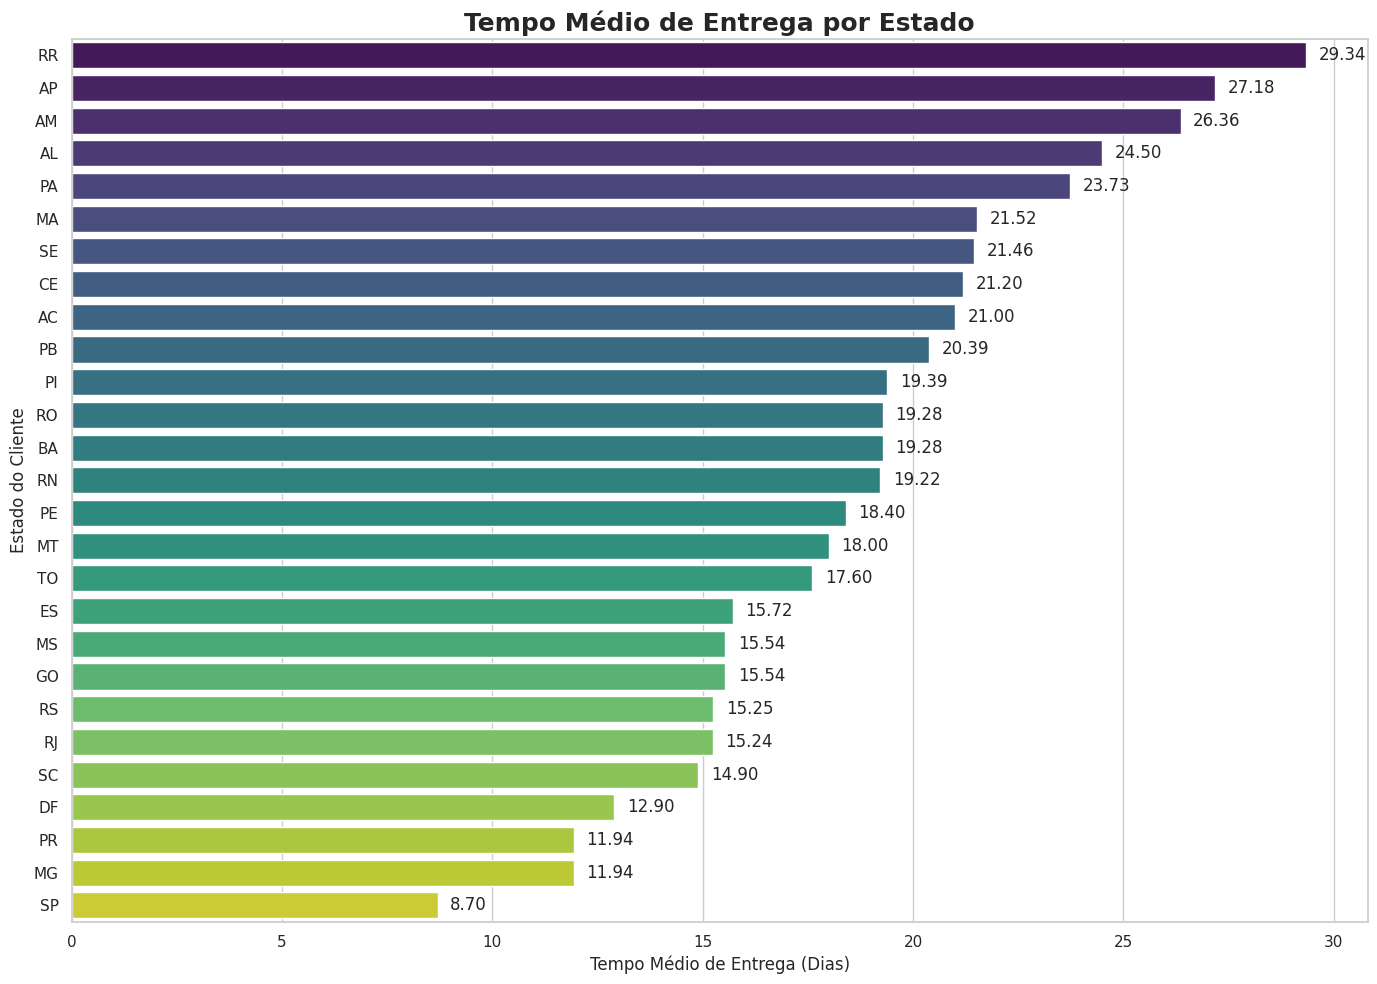

In [0]:
# Etapa 3: Análise do Tempo de Entrega por Estado

# 1. Agregação por Estado 
# Calcula o tempo médio de entrega para cada estado, ordena do maior para o menor,
# e converte o resultado para um DataFrame Pandas para a visualização.
avg_delivery_time_by_state = final_analysis_df.groupBy("customer_state") \
    .agg(F.round(F.avg("tempo_de_entrega_dias"), 2).alias("tempo_medio_entrega_dias")) \
    .orderBy(F.col("tempo_medio_entrega_dias").desc()) \
    .toPandas()

# 2. Visualização dos Resultados 
# Cria um gráfico de barras horizontais para comparar o tempo de entrega entre os estados.
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x="tempo_medio_entrega_dias", 
    y="customer_state", 
    data=avg_delivery_time_by_state, 
    palette="viridis"
)

# Define os títulos e rótulos do gráfico.
plt.title('Tempo Médio de Entrega por Estado', fontsize=18, weight='bold')
plt.xlabel('Tempo Médio de Entrega (Dias)', fontsize=12)
plt.ylabel('Estado do Cliente', fontsize=12)

# Adiciona o valor exato no final de cada barra para maior clareza.
for p in ax.patches:
    width = p.get_width()
    plt.text(x=width + 0.3, 
             y=p.get_y() + p.get_height() / 2, 
             s=f'{width:.2f}', 
             va='center')

# Ajusta o layout e exibe o gráfico.
plt.tight_layout()
plt.show()

### Etapa 4: Diagnóstico Geral dos Atrasos

Após analisar a dimensão geográfica, esta etapa quantifica a magnitude geral do problema de **atrasos**. A análise é dividida em duas perguntas fundamentais:

1. **Qual a proporção de todos os pedidos que são entregues com atraso?**  
   Isso mede a **frequência** do problema em toda a operação.

2. **Quando um pedido atrasa, qual é a duração típica desse atraso?**  
   Isso mede a **severidade** do problema.

Para responder a essas perguntas, a célula a seguir cria uma **visualização combinada**:
- Um **gráfico de pizza** para mostrar a **proporção de pedidos com atraso**
- Um **histograma** para ilustrar a **distribuição dos dias de atraso**


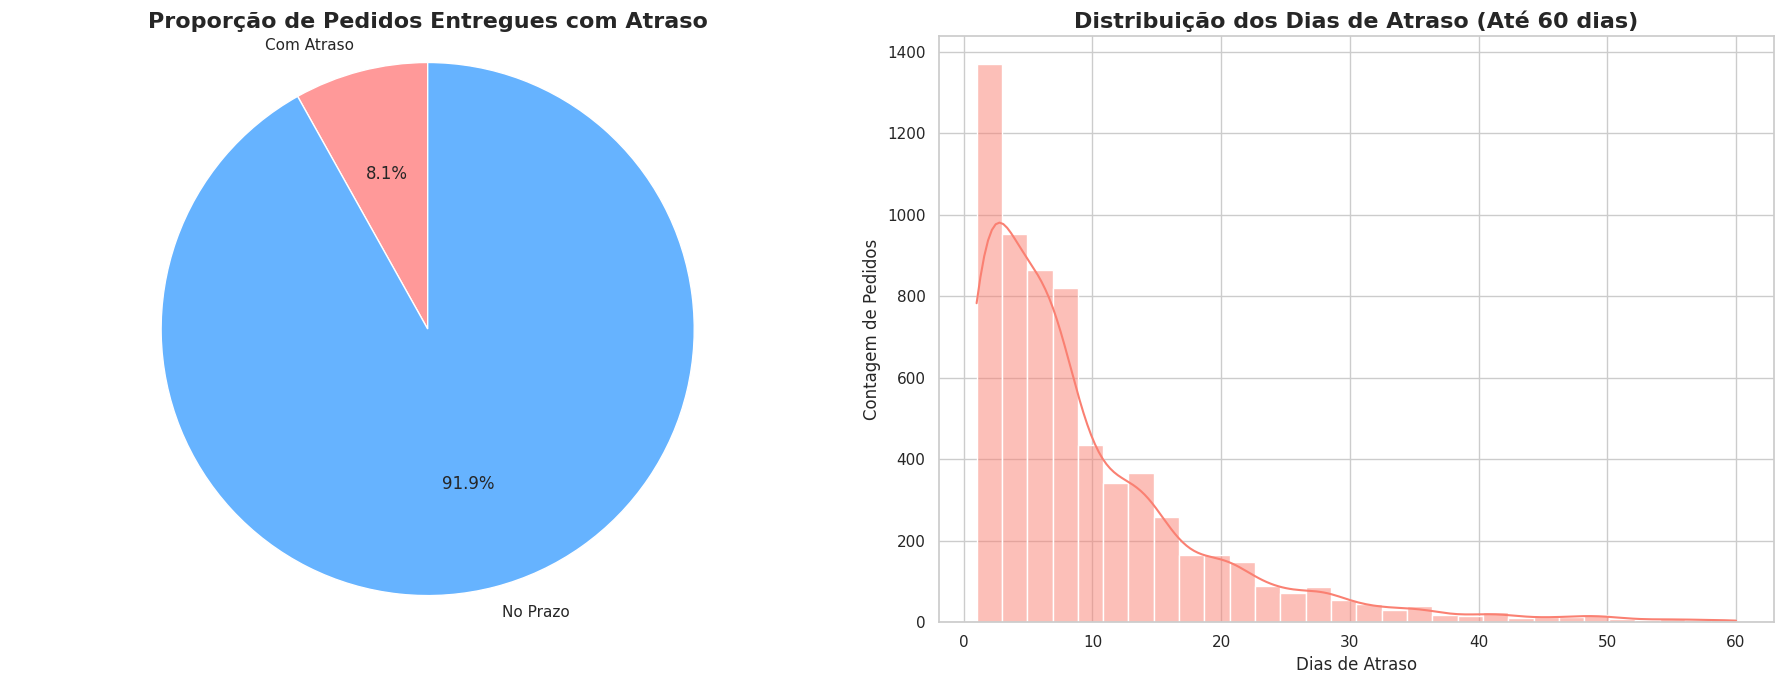

In [0]:
# Etapa 4: Diagnóstico Geral - Proporção e Distribuição dos Atrasos

#  1. Preparação dos Dados para o Gráfico de Pizza 
# Calcula a contagem de pedidos com e sem atraso.
status_counts_df = final_analysis_df.groupBy("foi_atrasado") \
    .count() \
    .toPandas()
# Adiciona uma coluna de status para os rótulos do gráfico.
status_counts_df['status'] = status_counts_df['foi_atrasado'].apply(lambda x: 'Com Atraso' if x == 1 else 'No Prazo')

#  2. Preparação dos Dados para o Histograma 
# Filtra apenas os pedidos com atraso (até 60 dias) para analisar a distribuição.
histogram_df = final_analysis_df.filter((F.col("dias_de_atraso") > 0) & (F.col("dias_de_atraso") <= 60)) \
    .select("dias_de_atraso") \
    .toPandas()

#  3. Criação da Visualização Combinada 
# Configura uma figura com dois subplots lado a lado.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de Pizza: Proporção de Atrasos
ax1.pie(status_counts_df['count'], labels=status_counts_df['status'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
ax1.set_title('Proporção de Pedidos Entregues com Atraso', fontsize=16, weight='bold')
ax1.axis('equal')  # Garante que a pizza seja um círculo.

# Histograma: Distribuição dos Dias de Atraso
sns.histplot(data=histogram_df, x='dias_de_atraso', bins=30, kde=True, ax=ax2, color='salmon')
ax2.set_title('Distribuição dos Dias de Atraso (Até 60 dias)', fontsize=16, weight='bold')
ax2.set_xlabel('Dias de Atraso', fontsize=12)
ax2.set_ylabel('Contagem de Pedidos', fontsize=12)

# Ajusta o layout e exibe o gráfico.
plt.tight_layout()
plt.show()

### Etapa 5: Análise de Fatores de Atraso - Tipo de Entrega e Geografia

Após o diagnóstico geral, a análise agora busca identificar **fatores que podem explicar os atrasos**. Esta etapa investiga a influência da **complexidade logística**, testando duas hipóteses:

1. **Entregas Interestaduais vs. Estaduais**  
   Comparam-se as métricas de atraso para entregas que **cruzam fronteiras estaduais** com aquelas que permanecem **no mesmo estado**.  
   > **Hipótese:** Rotas mais longas e complexas (interestaduais) são mais propensas a atrasos.

2. **Desempenho por Estado (Dados de Apoio)**  
   É gerada uma **tabela detalhada** com o **atraso médio** e o **volume de pedidos** para cada estado.  
   Este material serve como um **complemento à visualização da Etapa 3**, permitindo uma consulta mais **granular** dos dados.


In [0]:
# Etapa 5: Análise de Fatores de Atraso - Tipo de Entrega e Geografia

# 1. Análise por Tipo de Entrega 
# Calcula a taxa de atraso e o atraso médio para entregas Estaduais vs. Interestaduais.
taxa_atraso_por_tipo_entrega = final_analysis_df.groupBy("tipo_entrega") \
    .agg(
        F.round(F.avg("foi_atrasado") * 100, 2).alias("taxa_atraso_percentual"),
        F.round(F.avg("dias_de_atraso"), 2).alias("atraso_medio_dias")
    )
print("✅ Análise de Atraso por Tipo de Entrega (Estadual vs. Interestadual):")
display(taxa_atraso_por_tipo_entrega)


# 2. Análise por Estado do Cliente 
# Calcula o atraso médio e o volume total de pedidos por estado.
# A inclusão do 'total_pedidos' fornece contexto sobre o impacto do atraso médio.
atraso_por_estado_df = final_analysis_df.groupBy("customer_state") \
    .agg(
        F.round(F.avg("dias_de_atraso"), 2).alias("atraso_medio_dias"),
        F.count("order_id").alias("total_pedidos")
    ) \
    .orderBy(F.col("atraso_medio_dias").desc()) # Ordena para destacar os estados com maior atraso médio

print("\n✅ Análise de Atraso por Estado do Cliente:")
display(atraso_por_estado_df)

✅ Análise de Atraso por Tipo de Entrega (Estadual vs. Interestadual):


tipo_entrega,taxa_atraso_percentual,atraso_medio_dias
Interestadual,9.27,0.92
Estadual,6.06,0.35



✅ Análise de Atraso por Estado do Cliente:


customer_state,atraso_medio_dias,total_pedidos
RR,4.44,41
SE,2.47,335
AP,2.16,67
CE,2.09,1278
AL,2.04,397
PI,1.85,476
MA,1.83,716
RJ,1.64,12348
BA,1.46,3256
PA,1.44,946


### Etapa 6: Análise de Impacto do Atraso na Satisfação do Cliente

Após analisar as **causas** e a **frequência dos atrasos**, a pergunta final — e mais estratégica — é:

> **"Atrasos na entrega realmente impactam a avaliação que o cliente dá ao pedido?"**

Para responder a isso, esta análise **cruza os dados logísticos com as avaliações dos clientes** (*reviews*).

O código a seguir calcula a **nota média da avaliação (`review_score`)** para dois grupos distintos:

- Pedidos **entregues no prazo**
- Pedidos **entregues com atraso**

O resultado é visualizado em um **gráfico de barras**, permitindo:

- **Comparar diretamente os níveis de satisfação**
- **Quantificar o "custo" de um atraso** na percepção do cliente


✅ Análise de Satisfação vs. Atraso:


foi_atrasado,nota_media_avaliacao,total_pedidos,status_entrega
1,2.57,7660,Com Atraso
0,4.29,88149,No Prazo


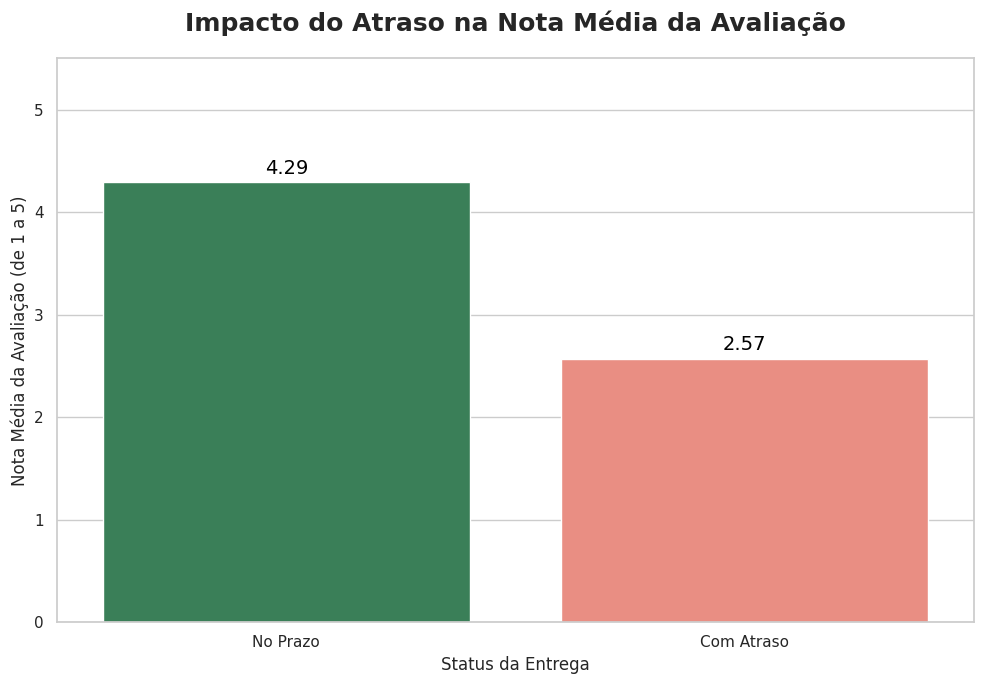

In [0]:
# Etapa 6: Impacto do Atraso na Satisfação do Cliente

# 1. Preparação dos Dados 
# Junta os dados de análise com as avaliações dos clientes.
reviews_analysis_df = final_analysis_df.join(reviews_df, "order_id", "left") \
    .dropDuplicates(["order_id"]) # Garante um pedido por linha

# Calcula a nota média da avaliação para pedidos com e sem atraso.
satisfaction_df = reviews_analysis_df \
    .filter(F.col("review_score").isNotNull()) \
    .groupBy("foi_atrasado") \
    .agg(
        F.round(F.avg("review_score"), 2).alias("nota_media_avaliacao"),
        F.count("order_id").alias("total_pedidos")
    ) \
    .withColumn("status_entrega", F.when(F.col("foi_atrasado") == 1, "Com Atraso").otherwise("No Prazo"))

print("✅ Análise de Satisfação vs. Atraso:")
display(satisfaction_df)

# 2. Preparação para Visualização 
# Converte o resultado para Pandas para usar no Seaborn/Matplotlib.
pandas_satisfaction = satisfaction_df.toPandas()

# 3. Criação da Visualização 
# Configura o tema e o tamanho do gráfico.
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Cria o gráfico de barras comparativo.
ax = sns.barplot(
    x="status_entrega",
    y="nota_media_avaliacao",
    data=pandas_satisfaction,
    palette={"No Prazo": "seagreen", "Com Atraso": "salmon"}, # Cores intuitivas
    order=["No Prazo", "Com Atraso"] # Garante a ordem das barras
)

# 4. Adição de Contexto ao Gráfico 
# Define os títulos e rótulos.
plt.title('Impacto do Atraso na Nota Média da Avaliação', fontsize=18, weight='bold', pad=20)
plt.xlabel('Status da Entrega', fontsize=12)
plt.ylabel('Nota Média da Avaliação (de 1 a 5)', fontsize=12)
plt.ylim(0, 5.5) # Define o limite do eixo Y para a escala de 1 a 5.

# Adiciona os rótulos de dados (valores) em cima de cada barra.
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=14, color='black',
                xytext=(0, 10),
                textcoords='offset points')

# Exibe o gráfico.
plt.tight_layout()
plt.show()

### Etapa 7: Análise de Causa Raiz — Pareto dos Atrasos por Categoria

Para identificar as **prioridades de melhoria logística** de forma estratégica, esta análise **abandona a tradicional listagem "Top X"** e aplica o **Princípio de Pareto**.

> **Objetivo:** Encontrar o menor conjunto de categorias que, somadas, representam **80% do volume de pedidos atrasados**.

Essa abordagem permite:

- **Focar os recursos de otimização** onde eles trarão maior impacto
- **Melhorar a experiência do cliente** de forma mais eficiente e direcionada


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


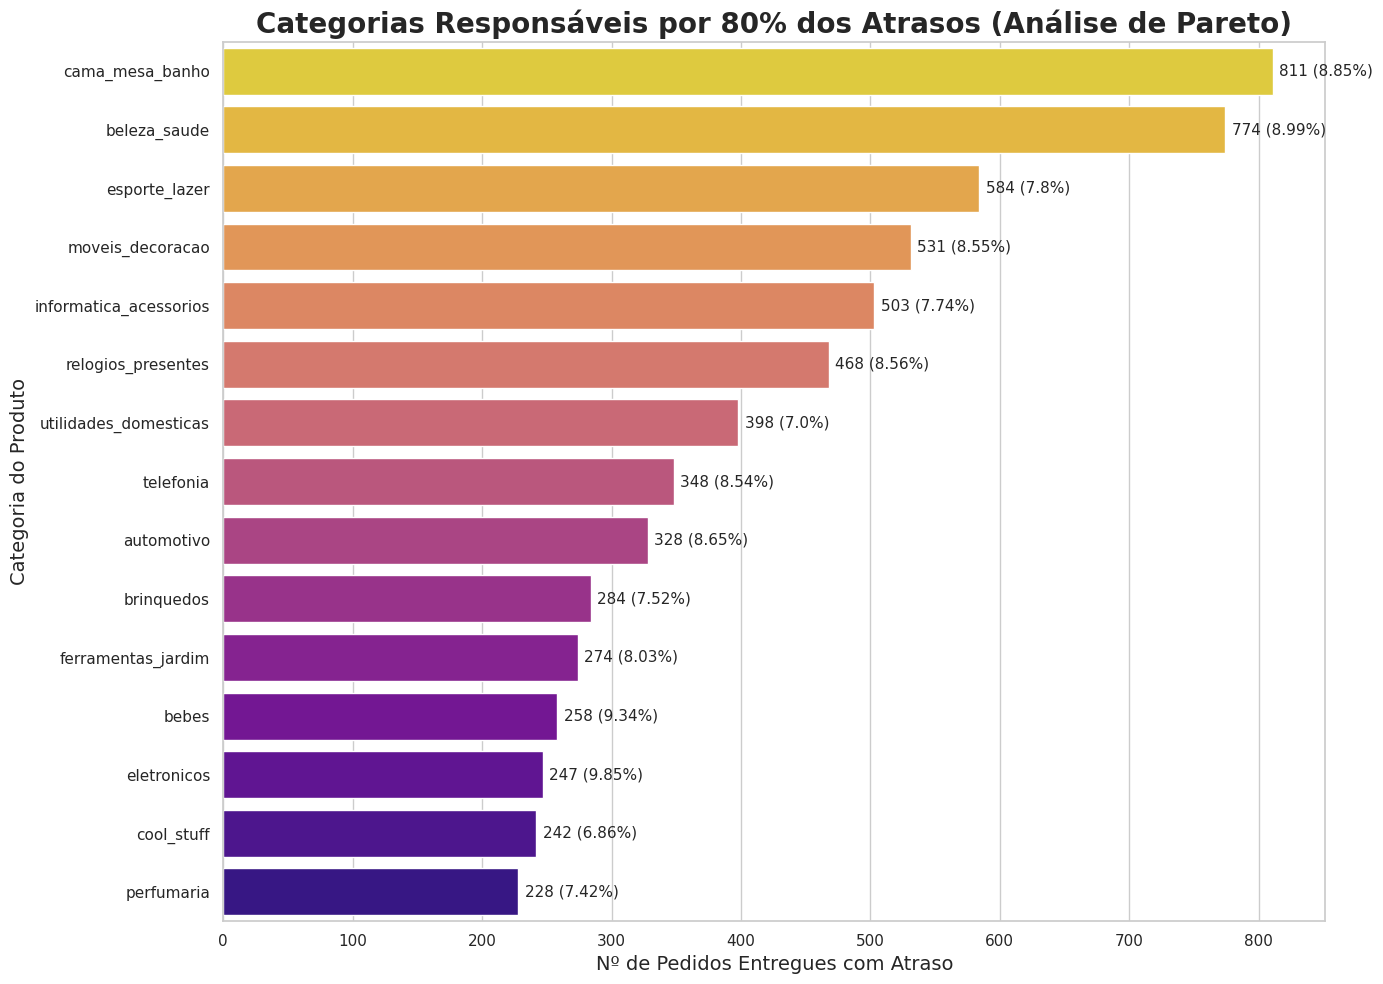

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
# Etapa 7: Análise de Pareto dos Pedidos Atrasados

# 1. Cálculo do Impacto por Categoria e do Total Geral 
# Calcula o número de atrasos e a taxa de atraso para cada categoria.
category_impact_df = final_analysis_df.groupBy("product_category_name").agg(
    F.sum("foi_atrasado").alias("total_pedidos_atrasados"),
    F.round((F.avg("foi_atrasado") * 100), 2).alias("taxa_atraso_percentual")
).filter(F.col("total_pedidos_atrasados") > 0) # Considera apenas categorias que tiveram atrasos

# Calcula o total geral de pedidos atrasados em todo o dataset.
total_geral_atrasos = final_analysis_df.agg(F.sum("foi_atrasado")).first()[0]


# 2. Aplicação da Lógica de Pareto com Window Functions 
# Define uma janela de agregação ordenada pelo número de atrasos.
window_spec = Window.orderBy(F.col("total_pedidos_atrasados").desc())

# Calcula o percentual acumulado de atrasos e filtra pelas categorias que somam até 80%.
pareto_atrasos_df = category_impact_df.withColumn(
    "percentual_acumulado",
    (F.sum("total_pedidos_atrasados").over(window_spec) / total_geral_atrasos) * 100
).filter(F.col("percentual_acumulado") <= 80.5) # Usa 80.5 para garantir que o ponto de 80% seja incluído


# 3. Preparação para Visualização 
pareto_pd = pareto_atrasos_df.orderBy("total_pedidos_atrasados", ascending=False).toPandas()


# 4. Criação do Gráfico de Barras Horizontais 
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=pareto_pd,
    x="total_pedidos_atrasados",
    y="product_category_name",
    palette="plasma_r"
)

# 5. Adição de Contexto ao Gráfico 
plt.title('Categorias Responsáveis por 80% dos Atrasos (Análise de Pareto)', fontsize=20, weight='bold')
plt.xlabel('Nº de Pedidos Entregues com Atraso', fontsize=14)
plt.ylabel('Categoria do Produto', fontsize=14)

# Adiciona rótulos informativos no final de cada barra (LÓGICA CORRIGIDA).
# Itera sobre as linhas do DataFrame para garantir a correspondência correta com as barras.
for index, row in pareto_pd.iterrows():
    # Usa o índice da linha para encontrar a barra correta
    bar = ax.patches[index]
    width = bar.get_width()
    taxa = row['taxa_atraso_percentual'] # Pega a taxa diretamente da linha

    ax.text(width + 5, # Posição x (um pouco depois da barra)
            bar.get_y() + bar.get_height() / 2, # Posição y (no meio da barra)
            f'{int(width)} ({taxa}%)', # Texto: "N (taxa%)"
            va='center',
            fontsize=11)

plt.tight_layout()
plt.show()

### Etapa 8: Preparação para Análise Sazonal de Atrasos

Esta etapa visa entender a sazonalidade dos atrasos nas entregas ao longo do tempo, utilizando engenharia temporal e agregações mensais para revelar padrões comportamentais.


### Engenharia de Feature Temporal

Criação de uma nova coluna `ano_mes_compra` no formato **AAAA-MM**, extraída da data de compra (`order_purchase_timestamp`).  
Essa coluna permite agrupar os dados por mês e ano, facilitando a análise sazonal dos atrasos.


In [0]:
# Etapa 8: Preparação para Análise Sazonal de Atrasos

# 1. Engenharia de Feature Temporal 
# Cria uma coluna 'ano_mes_compra' no formato 'AAAA-MM' para permitir o agrupamento mensal.
seasonal_analysis_df = final_analysis_df.withColumn(
    "ano_mes_compra",
    F.date_format(F.col("order_purchase_timestamp"), "yyyy-MM")
)

# 2. Agregação Mensal 
# Agrupa os dados por mês/ano para calcular as métricas de logística ao longo do tempo.
monthly_delay_df = seasonal_analysis_df \
    .groupBy("ano_mes_compra") \
    .agg(
        F.round(F.avg("foi_atrasado") * 100, 2).alias("taxa_atraso_percentual"),
        F.count("order_id").alias("total_pedidos")
    ) \
    .orderBy("ano_mes_compra")

# 3. Verificação 
# Exibe uma amostra dos dados agregados para confirmar que o cálculo está correto.
print("✅ Análise Sazonal de Atrasos:")
display(monthly_delay_df)

✅ Análise Sazonal de Atrasos:


ano_mes_compra,taxa_atraso_percentual,total_pedidos
2016-09,100.0,1
2016-10,1.13,265
2016-12,0.0,1
2017-01,3.07,748
2017-02,3.23,1641
2017-03,5.58,2546
2017-04,7.86,2303
2017-05,3.61,3545
2017-06,3.86,3135
2017-07,3.43,3872


### Etapa 9: Visualização da Sazonalidade dos Atrasos

Esta etapa visualiza os dados agregados **mensalmente**, conforme construído na etapa anterior.

> **Objetivo:** Confirmar ou refutar a hipótese de que a performance logística **se deteriora em períodos de alta demanda**.

Para isso, utiliza-se um **gráfico de eixo duplo**, técnica eficaz para comparar duas métricas com escalas diferentes ao longo do mesmo eixo de tempo:

- **Barras (Eixo Esquerdo):** Volume total de pedidos por mês  
- **Linha (Eixo Direito):** Taxa percentual de atrasos no mesmo período

Ao sobrepor essas duas métricas, é possível observar **visualmente se a linha de atraso (vermelha)** acompanha os **picos de volume**, como em períodos promocionais (ex: **Black Friday — novembro**).


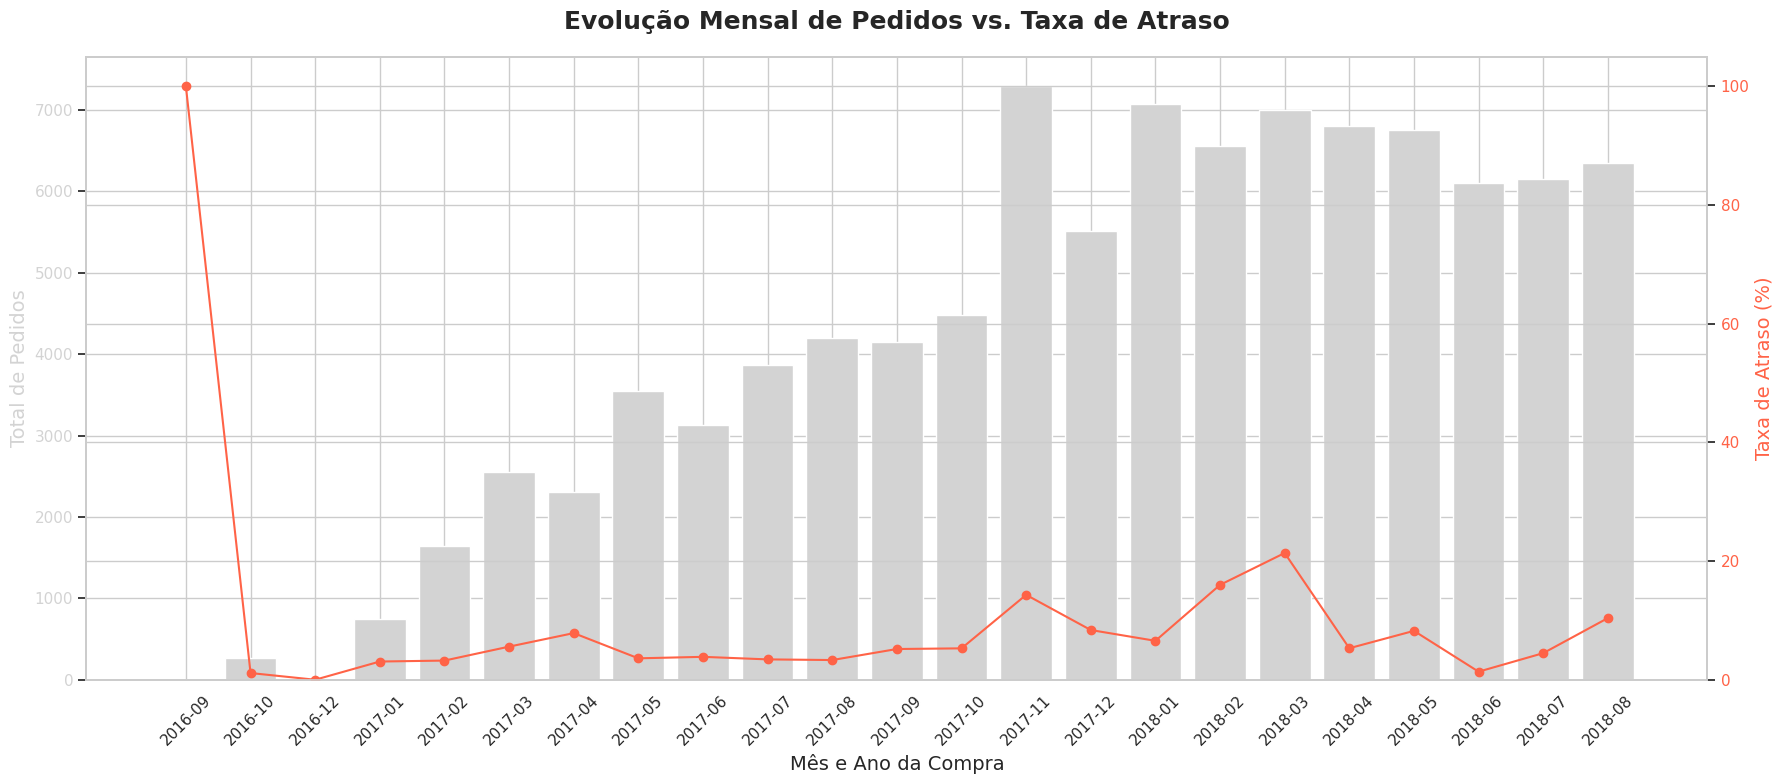

In [0]:
# Etapa 9: Visualização Sazonal - Volume de Pedidos vs. Taxa de Atraso

# 1. Preparação dos Dados 
# Converte o DataFrame Spark para Pandas para a visualização.
pandas_monthly_delay = monthly_delay_df.toPandas()

# 2. Configuração do Gráfico 
# Configura a figura e o eixo principal para o gráfico combinado.
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(18, 8))

# 3. Plotagem do Eixo Primário (Volume de Pedidos) 
# Plota o volume total de pedidos como barras no eixo Y primário (à esquerda).
color_bar = 'lightgrey'
ax1.set_xlabel('Mês e Ano da Compra', fontsize=14)
ax1.set_ylabel('Total de Pedidos', fontsize=14, color=color_bar)
ax1.bar(pandas_monthly_delay['ano_mes_compra'], pandas_monthly_delay['total_pedidos'], color=color_bar, label='Total de Pedidos')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.tick_params(axis='x', rotation=45)

# 4. Plotagem do Eixo Secundário (Taxa de Atraso) 
# Cria um segundo eixo Y que compartilha o mesmo eixo X e plota a taxa de atraso.
ax2 = ax1.twinx()
color_line = 'tomato'
ax2.set_ylabel('Taxa de Atraso (%)', fontsize=14, color=color_line)
ax2.plot(pandas_monthly_delay['ano_mes_compra'], pandas_monthly_delay['taxa_atraso_percentual'], color=color_line, marker='o', label='Taxa de Atraso (%)')
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.set_ylim(bottom=0)

# 5. Finalização e Título
# Adiciona o título e ajusta o layout para garantir a clareza.
plt.title('Evolução Mensal de Pedidos vs. Taxa de Atraso', fontsize=18, weight='bold', pad=20)
fig.tight_layout()
plt.show()

### Etapa 10: Análise do Impacto do Método de Pagamento

Nesta etapa, analisamos como diferentes métodos de pagamento impactam dois aspectos importantes da logística:

- O **tempo médio de aprovação** dos pedidos
- A **taxa de atraso na entrega**

### Agregação por Método de Pagamento

Os dados são agrupados por `payment_type` para calcular as seguintes métricas:

- **Tempo Médio de Aprovação (em horas)** (`tempo_medio_aprovacao_horas`)
- **Taxa de Atraso Percentual** (`taxa_atraso_percentual`)
- **Total de Pedidos** (`total_pedidos`)

✅ Análise do Impacto do Método de Pagamento:


payment_type,tempo_medio_aprovacao_horas,taxa_atraso_percentual,total_pedidos
boleto,33.01,8.89,19177
debit_card,9.12,7.95,1484
voucher,7.76,6.73,2734
credit_card,4.43,7.96,73059
null,0.0,100.0,1


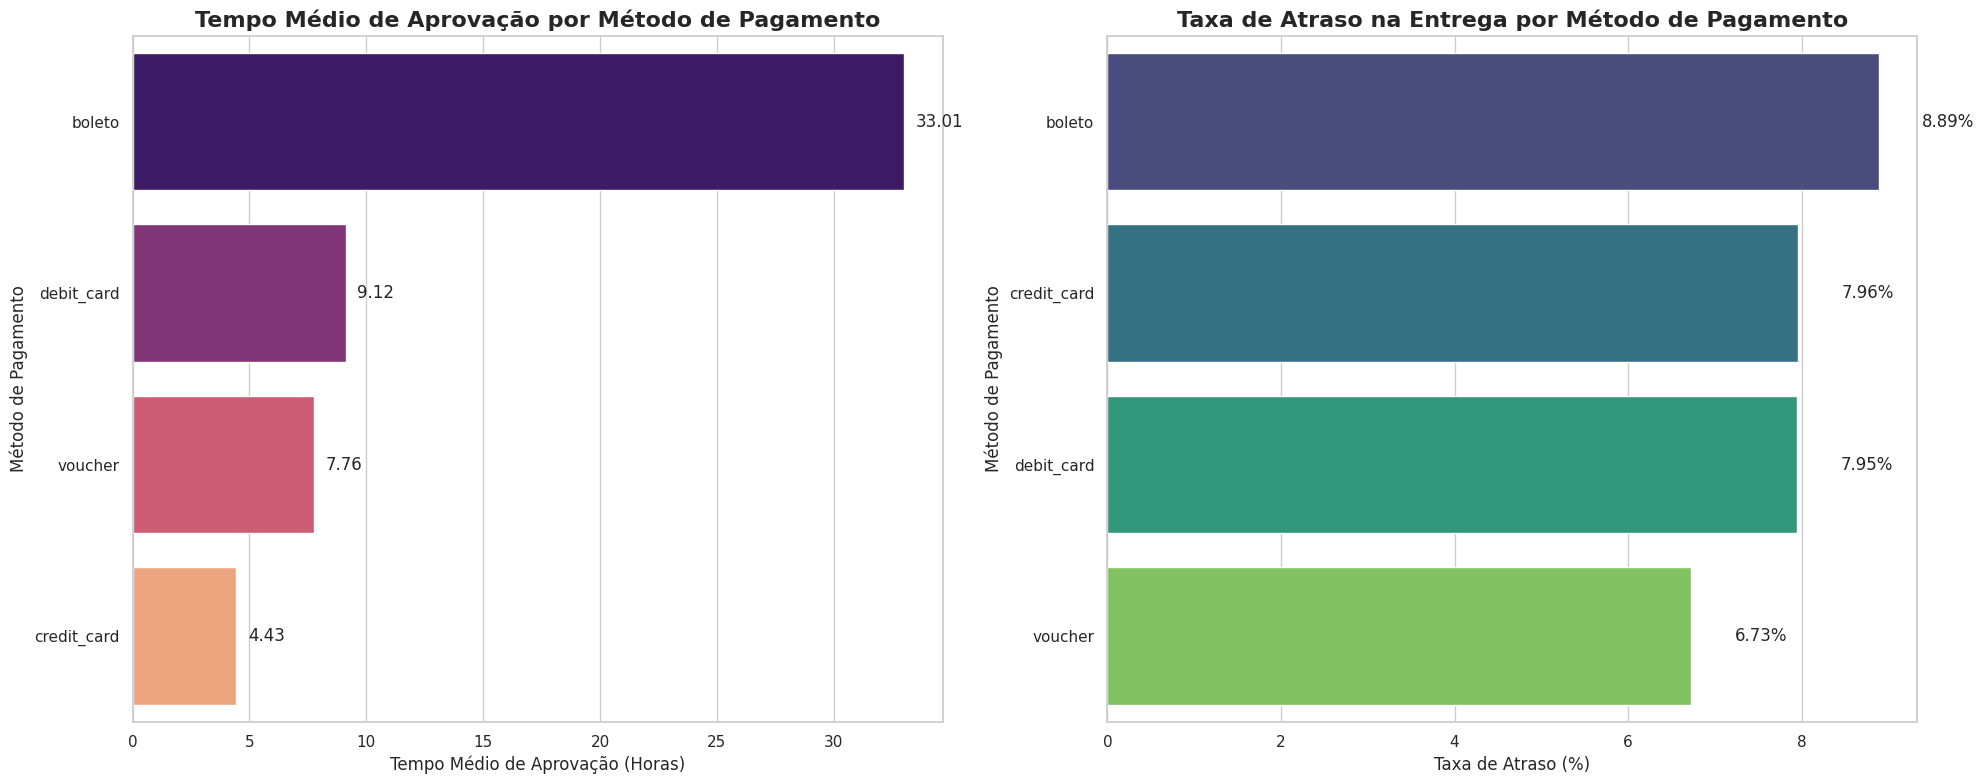

In [0]:
# Etapa 10: Análise do Impacto do Método de Pagamento

# 1. Agregação por Método de Pagamento
# Calcula o tempo médio de aprovação e a taxa de atraso para cada tipo de pagamento.
payment_impact_df = final_analysis_df.groupBy("payment_type").agg(
    F.round(F.avg("tempo_aprovacao_horas"), 2).alias("tempo_medio_aprovacao_horas"),
    F.round(F.avg("foi_atrasado") * 100, 2).alias("taxa_atraso_percentual"),
    F.count("order_id").alias("total_pedidos")
).orderBy(F.col("tempo_medio_aprovacao_horas").desc())

print("✅ Análise do Impacto do Método de Pagamento:")
display(payment_impact_df)

# 2. Preparação para Visualização
# Converte o DataFrame Spark para Pandas para a visualização.
pandas_payment_impact = payment_impact_df.toPandas()

# 3. Criação da Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.set_theme(style="whitegrid")

# Gráfico de Barras: Tempo Médio de Aprovação por Método de Pagamento
sns.barplot(
    x="tempo_medio_aprovacao_horas",
    y="payment_type",
    data=pandas_payment_impact.sort_values(by="tempo_medio_aprovacao_horas", ascending=False),
    palette="magma",
    ax=ax1
)
ax1.set_title('Tempo Médio de Aprovação por Método de Pagamento', fontsize=16, weight='bold')
ax1.set_xlabel('Tempo Médio de Aprovação (Horas)', fontsize=12)
ax1.set_ylabel('Método de Pagamento', fontsize=12)
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.5,
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}',
             va='center')

# Gráfico de Barras: Taxa de Atraso por Método de Pagamento
sns.barplot(
    x="taxa_atraso_percentual",
    y="payment_type",
    data=pandas_payment_impact.sort_values(by="taxa_atraso_percentual", ascending=False),
    palette="viridis",
    ax=ax2
)
ax2.set_title('Taxa de Atraso na Entrega por Método de Pagamento', fontsize=16, weight='bold')
ax2.set_xlabel('Taxa de Atraso (%)', fontsize=12)
ax2.set_ylabel('Método de Pagamento', fontsize=12)
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.5,
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}%',
             va='center')

plt.tight_layout()
plt.show()

### Conclusão da Análise Logística

A análise aprofundada da performance logística da operação de e-commerce revelou descobertas claras e quantificáveis sobre os prazos, a frequência e os principais fatores que influenciam os atrasos nas entregas. Os resultados confirmam que, embora a maioria das entregas ocorra no prazo, os atrasos representam um desafio significativo com impacto direto na satisfação do cliente.

#### Principais Conclusões:

- **Diagnóstico Geral do Problema:** A operação tem um desempenho majoritariamente positivo, com **91.9% das entregas sendo realizadas no prazo**. No entanto, os **8.1% de pedidos que atrasam** representam um volume considerável de clientes impactados. A maioria desses atrasos é de curta duração, concentrando-se nos **primeiros 10 dias após a data estimada**.

- **Impacto Crítico na Satisfação:** A pontualidade é um fator decisivo para a satisfação do cliente.  
  - Pedidos entregues **"No Prazo"** recebem uma **nota média de 4.29** de 5  
  - Pedidos **"Com Atraso"** caem para uma **média de 2.57** Essa **queda de quase 2 pontos** demonstra o alto custo de um atraso para a reputação da empresa.

- **A Complexidade do Frete é um Fator Chave:** A análise por tipo de entrega comprova que a logística **interestadual** é mais desafiadora.  
  - **Entregas Interestaduais:** 9.27% de taxa de atraso  
  - **Entregas Estaduais:** 6.06% de taxa de atraso  

- **Sazonalidade e Estresse Operacional:** A performance logística é diretamente impactada pelo volume de vendas.  
  - Em **novembro de 2017**, com mais de **7 mil pedidos**, a taxa de atraso chegou a **14.31%** - Em **março de 2018**, o pico de atraso chegou a **21.36%**, indicando que **outros fatores além do volume** podem gerar estresse na operação.

- **Pareto dos Problemas: Foco em Categorias Específicas:** A Análise de Pareto revelou que o problema de atrasos é altamente concentrado.  
  - Um grupo de **15 categorias** é responsável por **80% dos pedidos atrasados** - As categorias com maior impacto são:  
    - **cama_mesa_banho** - **beleza_saude** - **esporte_lazer** Estas representam os **principais pontos de atenção** para a equipe de logística.

- **Impacto do Método de Pagamento:**
  O método de pagamento influencia diretamente o tempo de aprovação e, consequentemente, pode impactar o tempo total de entrega.
  - Pagamentos via **boleto** apresentam um **tempo médio de aprovação significativamente maior (33.01 horas)** em comparação com outros métodos como **cartão de crédito (4.43 horas)**, **débito (9.12 horas)** ou **voucher (7.76 horas)**.
  - Apesar do tempo de aprovação mais longo, a **taxa de atraso** para pedidos pagos com **boleto (8.89%)** é comparável ou até ligeiramente superior à de **cartão de crédito (7.96%)** e **débito (7.95%)**. Isso sugere que, embora o boleto adicione um atraso inicial, ele não é o principal fator isolado que causa o atraso final na entrega, mas sim um contribuinte para o tempo total de processamento do pedido.